In [1]:
import pandas as pd

s_df = pd.read_csv('students.csv')
s_df

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317
...,...,...,...,...,...
313,314,0,0,0,244
314,315,1,0,0,309
315,316,0,0,0,239
316,317,1,0,0,356


In [2]:
s_df['gender'].value_counts()

0    160
1    158
Name: gender, dtype: int64

In [3]:
s_df['support_flag'].value_counts()

0    314
1      4
Name: support_flag, dtype: int64

In [4]:
s_df['leader_flag'].value_counts()

0    301
1     17
Name: leader_flag, dtype: int64

In [5]:
s_df['score'].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

<AxesSubplot:>

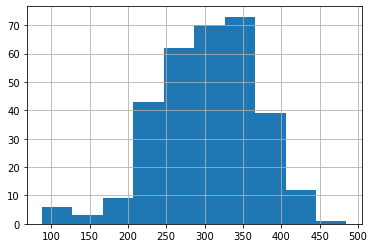

In [6]:
s_df['score'].hist()

In [7]:
s_pair_df = pd.read_csv('student_pairs.csv')
s_pair_df

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


In [8]:
from mip import *

m = Model()

S = s_df.student_id.tolist()
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

SC = [(s,c) for s in S for c in C]

x = m.add_var_tensor((len(S),len(C)), name='x', var_type=BINARY)

C_dict = {c:i for (c,i) in zip(C,range(len(C)))}
C_dict

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}

In [9]:
#Each student is allocated to exactly one class
for s in S:
    m += xsum(x[s-1,C_dict[c]] for c in C) == 1

#There are 39 or 40 students in each class
for c in C:
    m += xsum(x[s-1,C_dict[c]] for s in S) >=39
    m += xsum(x[s-1,C_dict[c]] for s in S) <=40

In [10]:
# 男子生徒のリスト
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]

# 女子生徒のリスト
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

In [11]:
# # of male and female students <= 20
for c in C:
    m += xsum(x[s-1,C_dict[c]] for s in S_male) <=20
    m += xsum(x[s-1,C_dict[c]] for s in S_female) <=20

In [12]:
score = {row.student_id:row.score for row in s_df.itertuples()}

# 平均点の算出
score_mean = s_df['score'].mean()
print(score_mean)

303.6446540880503


In [13]:
# Ave score of each class should be score_mean +- 10
for c in C:
    m += (score_mean - 10) * xsum([x[s-1,C_dict[c]] for s in S]) <= xsum([x[s-1,C_dict[c]] * score[s] for s in S])
    m += xsum([x[s-1,C_dict[c]] * score[s] for s in S]) <= (score_mean + 10) * xsum([x[s-1,C_dict[c]] for s in S])

In [14]:
# リーダー気質の生徒の集合
S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]

# (5)各クラスにリーダー気質の生徒を2人以上割り当てる。
for c in C:
    m += xsum([x[s-1,C_dict[c]] for s in S_leader]) >= 2

# 特別な支援が必要な生徒の集合
S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]

# (6) 特別な支援が必要な生徒は各クラスに1人以下とする。
for c in C:
    m += xsum([x[s-1,C_dict[c]] for s in S_support]) <= 1

    # 生徒の特定ペアリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_df.itertuples()]

# (7) 特定ペアの生徒は同一クラスに割り当てない。
for row in s_pair_df.itertuples():
    s1 = row.student_id1
    s2 = row.student_id2
    for c in C:
        m += x[s1-1,C_dict[c]] + x[s2-1,C_dict[c]] <= 1

In [15]:
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [16]:
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s-1,C_dict[c]].x==1]

In [17]:
for c, Ss in C2Ss.items():
    print('Class:', c)
    print('Num:', len(Ss))
    print('Student:', Ss)
    print()

Class: A
Num: 40
Student: [20, 64, 65, 70, 72, 84, 94, 96, 104, 105, 124, 133, 148, 151, 161, 166, 178, 188, 192, 196, 199, 203, 205, 224, 230, 234, 238, 241, 243, 247, 250, 253, 283, 284, 291, 294, 307, 308, 310, 315]

Class: B
Num: 40
Student: [4, 5, 8, 9, 22, 30, 32, 35, 36, 40, 41, 43, 68, 99, 108, 112, 116, 118, 121, 136, 137, 150, 152, 162, 167, 174, 182, 204, 215, 221, 228, 239, 240, 244, 251, 289, 295, 303, 313, 314]

Class: C
Num: 40
Student: [1, 2, 17, 18, 23, 29, 37, 46, 48, 60, 62, 71, 74, 76, 81, 88, 95, 103, 126, 131, 139, 140, 149, 153, 154, 179, 185, 198, 201, 209, 227, 231, 235, 246, 254, 263, 270, 272, 274, 276]

Class: D
Num: 40
Student: [3, 11, 15, 27, 28, 50, 54, 61, 73, 100, 107, 113, 114, 122, 125, 134, 146, 156, 159, 160, 187, 189, 211, 213, 223, 225, 229, 245, 255, 257, 260, 265, 266, 273, 278, 282, 287, 292, 306, 318]

Class: E
Num: 39
Student: [13, 14, 21, 25, 45, 47, 49, 52, 56, 57, 69, 75, 85, 87, 89, 90, 91, 97, 119, 130, 143, 163, 177, 183, 184, 193, 197,

In [18]:
C2Ss.items()

dict_items([('A', [20, 64, 65, 70, 72, 84, 94, 96, 104, 105, 124, 133, 148, 151, 161, 166, 178, 188, 192, 196, 199, 203, 205, 224, 230, 234, 238, 241, 243, 247, 250, 253, 283, 284, 291, 294, 307, 308, 310, 315]), ('B', [4, 5, 8, 9, 22, 30, 32, 35, 36, 40, 41, 43, 68, 99, 108, 112, 116, 118, 121, 136, 137, 150, 152, 162, 167, 174, 182, 204, 215, 221, 228, 239, 240, 244, 251, 289, 295, 303, 313, 314]), ('C', [1, 2, 17, 18, 23, 29, 37, 46, 48, 60, 62, 71, 74, 76, 81, 88, 95, 103, 126, 131, 139, 140, 149, 153, 154, 179, 185, 198, 201, 209, 227, 231, 235, 246, 254, 263, 270, 272, 274, 276]), ('D', [3, 11, 15, 27, 28, 50, 54, 61, 73, 100, 107, 113, 114, 122, 125, 134, 146, 156, 159, 160, 187, 189, 211, 213, 223, 225, 229, 245, 255, 257, 260, 265, 266, 273, 278, 282, 287, 292, 306, 318]), ('E', [13, 14, 21, 25, 45, 47, 49, 52, 56, 57, 69, 75, 85, 87, 89, 90, 91, 97, 119, 130, 143, 163, 177, 183, 184, 193, 197, 206, 210, 236, 242, 256, 258, 267, 277, 280, 296, 298, 317]), ('F', [7, 12, 33, 38,

### 解が条件を満たしているか確認

生徒が丁度1つのクラスに属しているか

In [19]:
for s in S:
    assigned_class = [x[s-1,C_dict[c]].x for c in C if x[s-1,C_dict[c]].x == 1]
    
    if len(assigned_class) != 1:
        print('error:', s, assigned_class)
    

検証用DataFrame

In [20]:
result_df = s_df.copy()

S2C = {s:c for s in S for c in C if x[s-1,C_dict[c]].x == 1}

result_df['assigned_class'] = result_df['student_id'].map(S2C)
result_df

,student_id,gender,leader_flag,support_flag,score,assigned_class
0,1,0,0,0,335,C
1,2,1,0,0,379,C
2,3,0,0,0,350,D
3,4,0,0,0,301,B
4,5,1,0,0,317,B
...,...,...,...,...,...,...
313,314,0,0,0,244,B
314,315,1,0,0,309,A
315,316,0,0,0,239,H
316,317,1,0,0,356,E


In [21]:
result_df.groupby('assigned_class').student_id.count()

assigned_class
A    40
B    40
C    40
D    40
E    39
F    40
G    40
H    39
Name: student_id, dtype: int64

In [22]:
result_df.groupby(['assigned_class', 'gender']).student_id.count()

assigned_class  gender
A               0         20
                1         20
B               0         20
                1         20
C               0         20
                1         20
D               0         20
                1         20
E               0         20
                1         19
F               0         20
                1         20
G               0         20
                1         20
H               0         20
                1         19
Name: student_id, dtype: int64

In [23]:
result_df.groupby('assigned_class').score.mean()

assigned_class
A    296.625000
B    312.175000
C    303.525000
D    294.050000
E    313.153846
F    302.400000
G    313.250000
H    293.974359
Name: score, dtype: float64

In [24]:
result_df.groupby(['assigned_class']).leader_flag.sum()

assigned_class
A    2
B    2
C    2
D    2
E    3
F    2
G    2
H    2
Name: leader_flag, dtype: int64

In [25]:
result_df.groupby(['assigned_class']).support_flag.sum()

assigned_class
A    0
B    0
C    1
D    1
E    1
F    0
G    0
H    1
Name: support_flag, dtype: int64

In [26]:
for i, (s1, s2) in enumerate(SS):
    print('case:',i)
    c1 = S2C[s1]
    c2 = S2C[s2]
    print('s1:{}-{}'.format(s1, c1))
    print('s2:{}-{}'.format(s2, c2))
    print('')

case: 0
s1:118-B
s2:189-D

case: 1
s1:72-A
s2:50-D

case: 2
s1:314-B
s2:233-G



### 制約の見直し

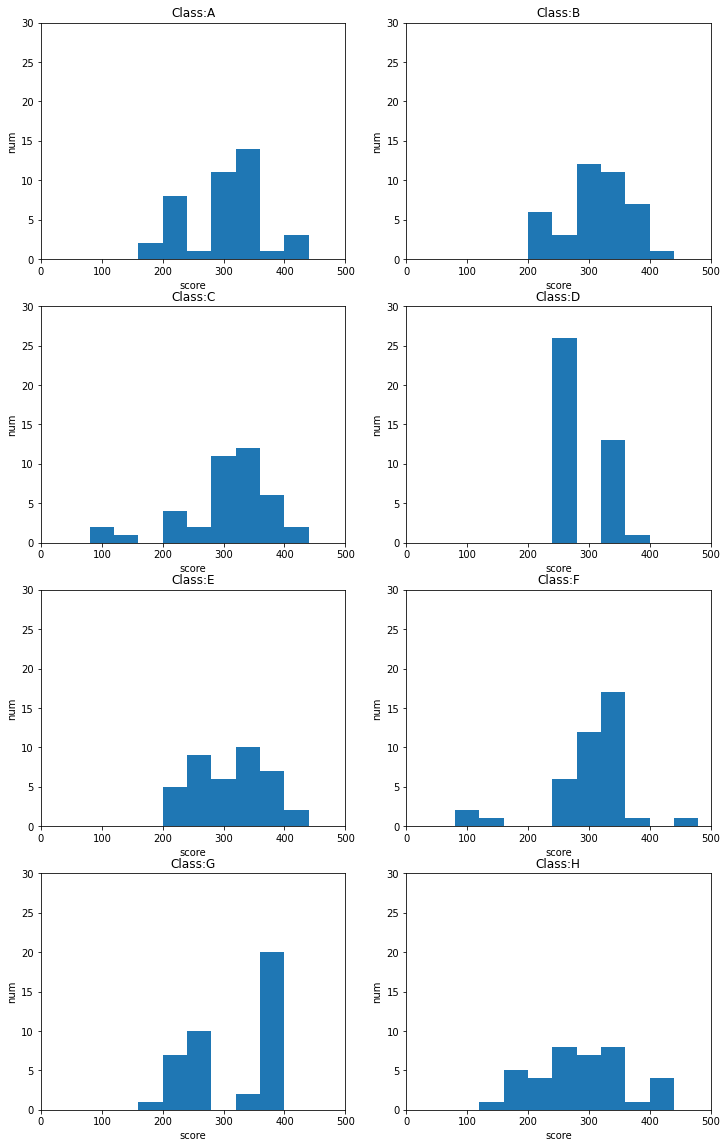

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_df = result_df[result_df['assigned_class']==c]
    ax = fig.add_subplot(4
                         , 2
                         , i+1
                         , xlabel='score'
                         , ylabel='num'
                         , xlim=(0, 500)
                         , ylim=(0, 30)
                         , title='Class:{:s}'.format(c)
                        )
    ax.hist(cls_df['score'], bins=range(0,500,40))

### モデルの修正

In [28]:
# 学力をもとに順位を付与
s_df['score_rank'] = s_df['score'].rank(ascending=False, method='first') 

# 学力順にクラス編成し、init_assigned_classカラムを作成
class_dic = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H'}
s_df['init_assigned_class'] = s_df['score_rank'].map(lambda x:x % 8).map(class_dic)
s_df

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class
0,1,0,0,0,335,109.0,F
1,2,1,0,0,379,38.0,G
2,3,0,0,0,350,79.0,H
3,4,0,0,0,301,172.0,E
4,5,1,0,0,317,147.0,D
...,...,...,...,...,...,...,...
313,314,0,0,0,244,263.0,H
314,315,1,0,0,309,162.0,C
315,316,0,0,0,239,272.0,A
316,317,1,0,0,356,63.0,H


In [29]:
init_flag = {(s,c):0 for s in S for c in C}

for row in s_df.itertuples():
    init_flag[row.student_id, row.init_assigned_class] = 1

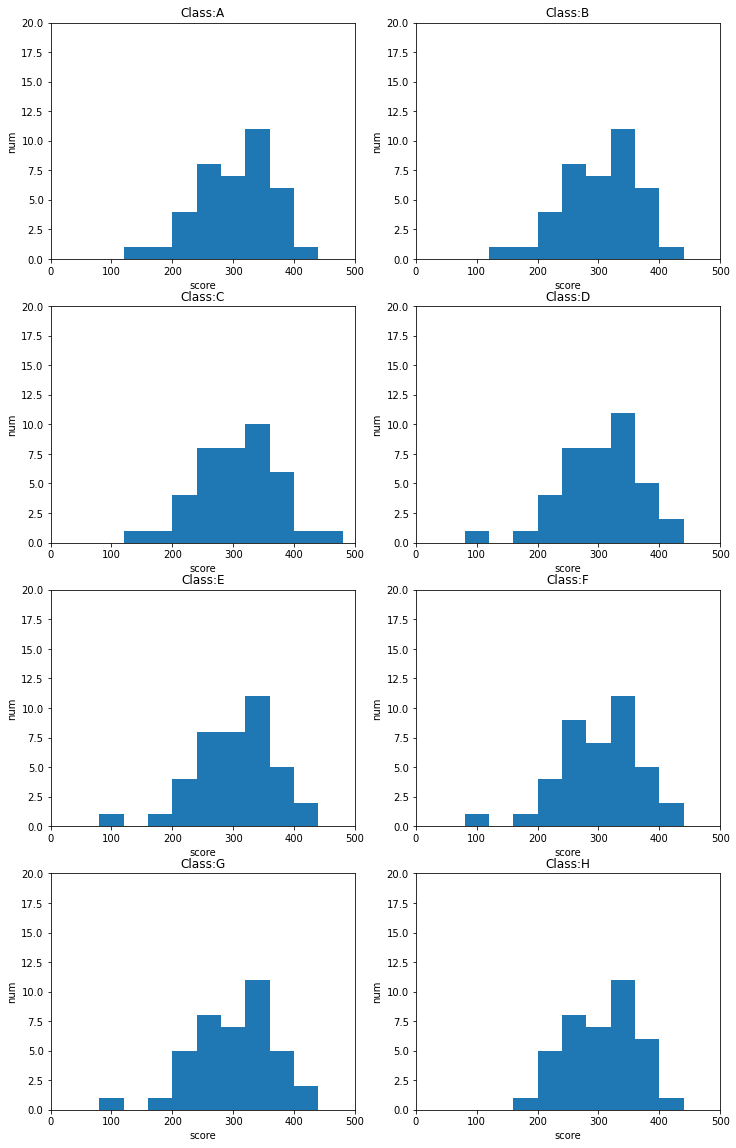

In [30]:
fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_df = s_df[s_df['init_assigned_class']==c]
    ax = fig.add_subplot(4
                         , 2
                         , i+1
                         , xlabel='score'
                         , ylabel='num'
                         , xlim=(0, 500)
                         , ylim=(0, 20)
                         , title='Class:{:s}'.format(c)
                        )
    ax.hist(cls_df['score'], bins=range(0,500,40))

### できる限り初期のクラス編成から動かさないように再最適化

In [31]:
m = Model()

S = s_df.student_id.tolist()
C = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

SC = [(s,c) for s in S for c in C]

x = m.add_var_tensor((len(S),len(C)), name='x', var_type=BINARY)

C_dict = {c:i for (c,i) in zip(C,range(len(C)))}

#Each student is allocated to exactly one class
for s in S:
    m += xsum(x[s-1,C_dict[c]] for c in C) == 1

#There are 39 or 40 students in each class
for c in C:
    m += xsum(x[s-1,C_dict[c]] for s in S) >=39
    m += xsum(x[s-1,C_dict[c]] for s in S) <=40

# 男子生徒のリスト
S_male = [row.student_id for row in s_df.itertuples() if row.gender == 1]

# 女子生徒のリスト
S_female = [row.student_id for row in s_df.itertuples() if row.gender == 0]

# # of male and female students <= 20
for c in C:
    m += xsum(x[s-1,C_dict[c]] for s in S_male) <=20
    m += xsum(x[s-1,C_dict[c]] for s in S_female) <=20
    

score = {row.student_id:row.score for row in s_df.itertuples()}

# 平均点の算出
score_mean = s_df['score'].mean()
print(score_mean)

# Ave score of each class should be score_mean +- 10
for c in C:
    m += (score_mean - 10) * xsum([x[s-1,C_dict[c]] for s in S]) <= xsum([x[s-1,C_dict[c]] * score[s] for s in S])
    m += xsum([x[s-1,C_dict[c]] * score[s] for s in S]) <= (score_mean + 10) * xsum([x[s-1,C_dict[c]] for s in S])
    
    # リーダー気質の生徒の集合
S_leader = [row.student_id for row in s_df.itertuples() if row.leader_flag == 1]

# (5)各クラスにリーダー気質の生徒を2人以上割り当てる。
for c in C:
    m += xsum([x[s-1,C_dict[c]] for s in S_leader]) >= 2

# 特別な支援が必要な生徒の集合
S_support = [row.student_id for row in s_df.itertuples() if row.support_flag == 1]

# (6) 特別な支援が必要な生徒は各クラスに1人以下とする。
for c in C:
    m += xsum([x[s-1,C_dict[c]] for s in S_support]) <= 1

    # 生徒の特定ペアリスト
SS = [(row.student_id1, row.student_id2) for row in s_pair_df.itertuples()]

# (7) 特定ペアの生徒は同一クラスに割り当てない。
for row in s_pair_df.itertuples():
    s1 = row.student_id1
    s2 = row.student_id2
    for c in C:
        m += x[s1-1,C_dict[c]] + x[s2-1,C_dict[c]] <= 1

303.6446540880503


In [32]:
m.objective = maximize(xsum(x[s-1,C_dict[c]] * init_flag[s,c] for s,c in SC))

In [33]:
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

In [34]:
result_df2 = s_df.copy()

S2C = {s:c for s in S for c in C if x[s-1,C_dict[c]].x == 1}

result_df2['assigned_class'] = result_df2['student_id'].map(S2C)

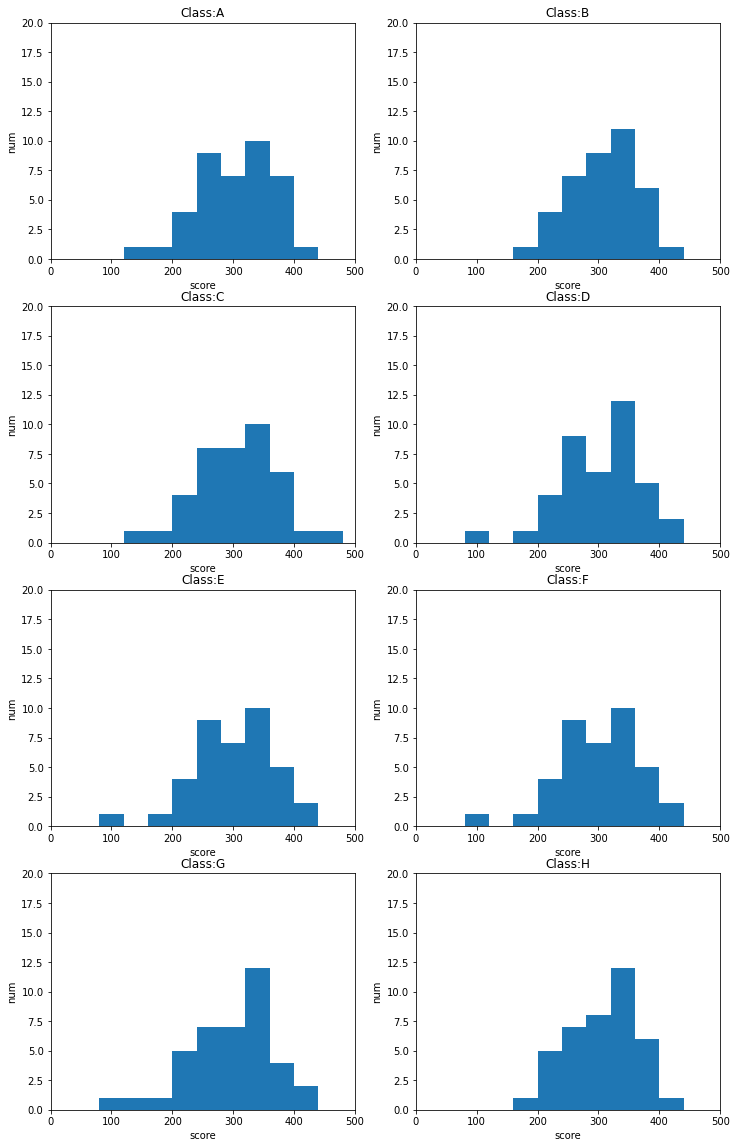

In [36]:
fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_df = result_df2[result_df2['assigned_class']==c]
    ax = fig.add_subplot(4
                         , 2
                         , i+1
                         , xlabel='score'
                         , ylabel='num'
                         , xlim=(0, 500)
                         , ylim=(0, 20)
                         , title='Class:{:s}'.format(c)
                        )
    ax.hist(cls_df['score'], bins=range(0,500,40))